In [1]:
import scanpy as sc
import numpy as np

# Loading data

In [2]:
#adata = sc.read_h5ad("/home/roger/send_data/combined_filtered_landscape.h5ad")

adata= sc.read_h5ad('/home/jing/Downloads/lypi_DATA/combined_filtered_landscape.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 130700 × 4814
    obs: 'n_genes', 'n_counts', 'mt_count', 'mt_frac', 'doublet_scores', 'predicted_doublets', 'xist_logn', 'Ygene_logn', 'xist_bin', 'Ygene_bin', 'sex_adata', 'biosample_id', 'cellid', 'RBG', 'SLXid', 'index', '10xsample_description', 'sex_mixed', 'sex_meta', 'mouse_id', 'sortedcells', 'expected_cells_10x', 'cellranger_cellsfound', 'chemistry', 'tom', 'expdate', 'batch', 'timepoint_tx_days', 'start_age', 'sample_id', 'countfile', 'S_score', 'G2M_score', 'phase', 'leiden', 'SLX', 'plate_sorted', 'plate_rearranged', 'well_sorted', 'well_rearranged', 'set_index', 'CI_index', 'mouse_platelabel', 'sort_method', 'sample.name', 'population', 'sex', 'countfolder', 'batch_plate_sorted', 'data_type', 'sex_combined', 'longname', 'anno_man', 'leiden_DM', 'HSCscore', 'nn_HSCscore', 'isroot', 'dpt_pseudotime'
    var: 'symbol', 'gene_ids-10x', 'feature_types-10x', 'genome-10x', 'n_counts-10x', 'highly_variable-10x', 'means-10x', 'dispersions-10x', 

# Cell visualization

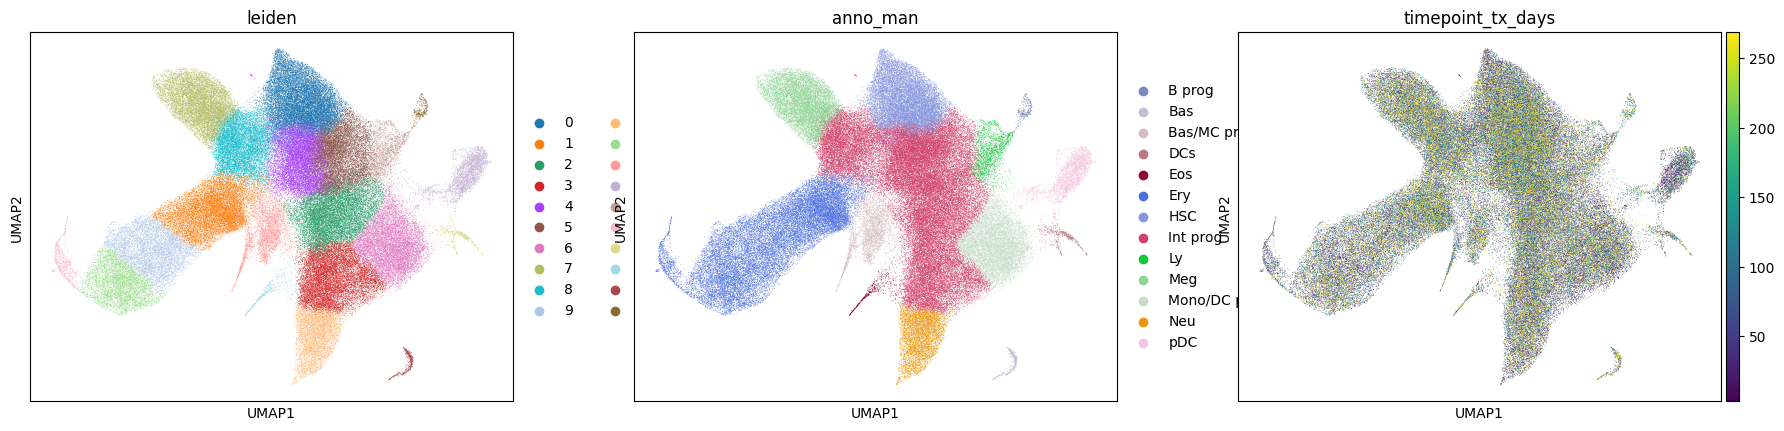

In [6]:
sc.pl.umap(adata, color=['leiden', 'anno_man', 'timepoint_tx_days'])

# Analyzing adata.raw containing target genes

In [4]:
# Create a new adata object using raw expression and raw var names
new_adata = sc.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs[['anno_man']])

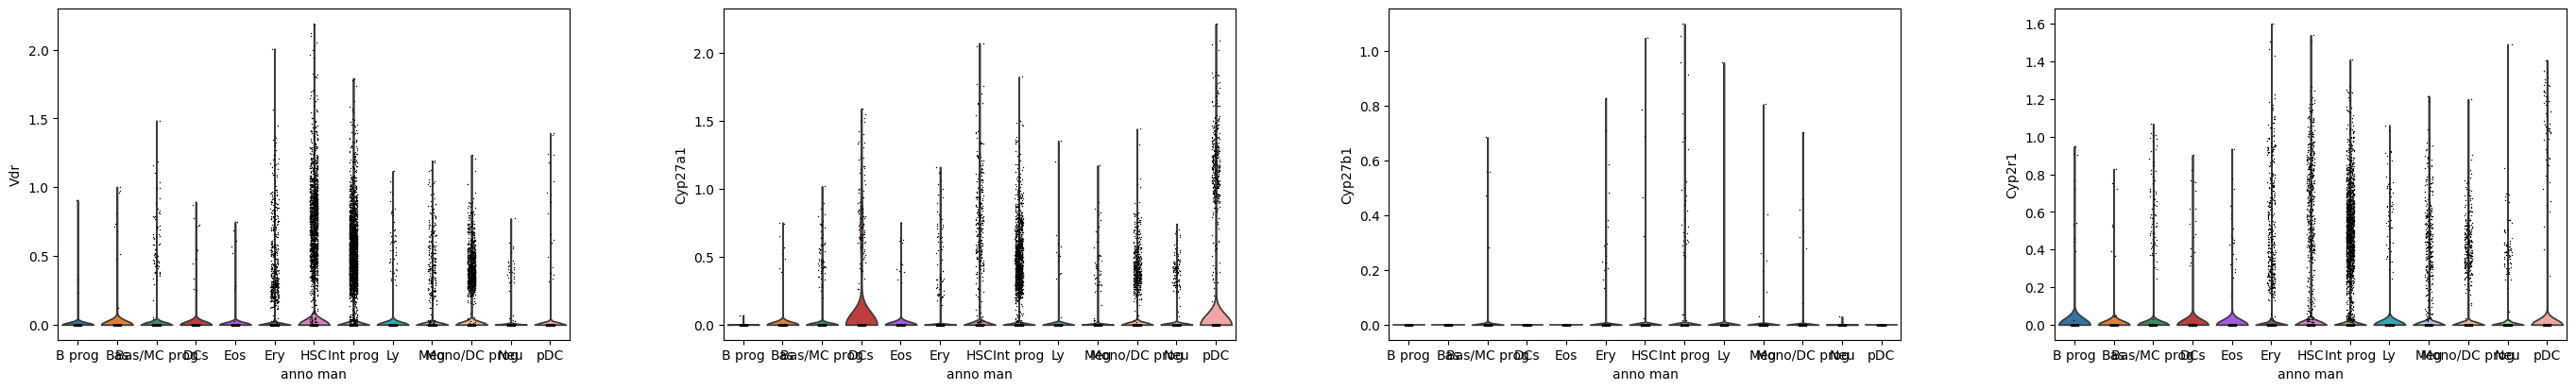

In [8]:
sc.pl.violin(new_adata, keys=["Vdr", "Cyp27a1", "Cyp27b1", "Cyp2r1"], groupby="anno_man")

#sampling
# Ensure there are at least 10,000 cells in the dataset
n_cells = min(20000, new_adata.n_obs)
random_indices = np.random.choice(new_adata.obs_names, size=n_cells, replace=False)
new_adata = new_adata[random_indices, :].copy()

In [5]:
# Basic pre-processing steps
new_adata.layers["counts"] = new_adata.X.copy()
sc.pp.normalize_total(new_adata)
sc.pp.log1p(new_adata)
sc.pp.highly_variable_genes(adata, n_top_genes=5000)
sc.tl.pca(new_adata)
sc.pp.neighbors(new_adata, n_neighbors=12, n_pcs=50)
sc.tl.umap(new_adata)
sc.tl.leiden(new_adata, resolution=1)


/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:305: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_84690/2144549267.py:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(new_adata, resolution=1)


In [6]:
new_adata.obs['batch']=adata.obs['batch']

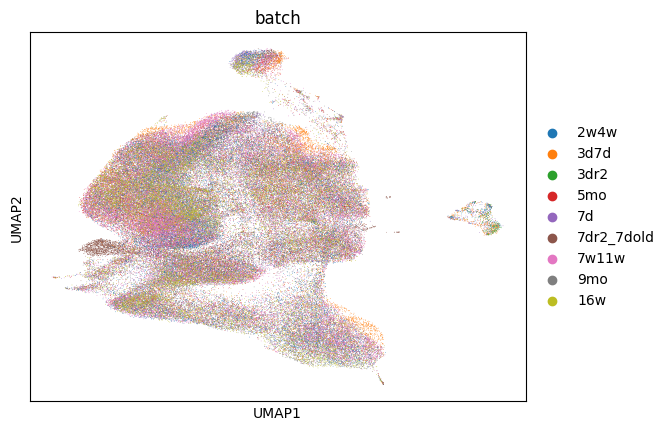

In [7]:
sc.pl.umap(new_adata,color='batch')

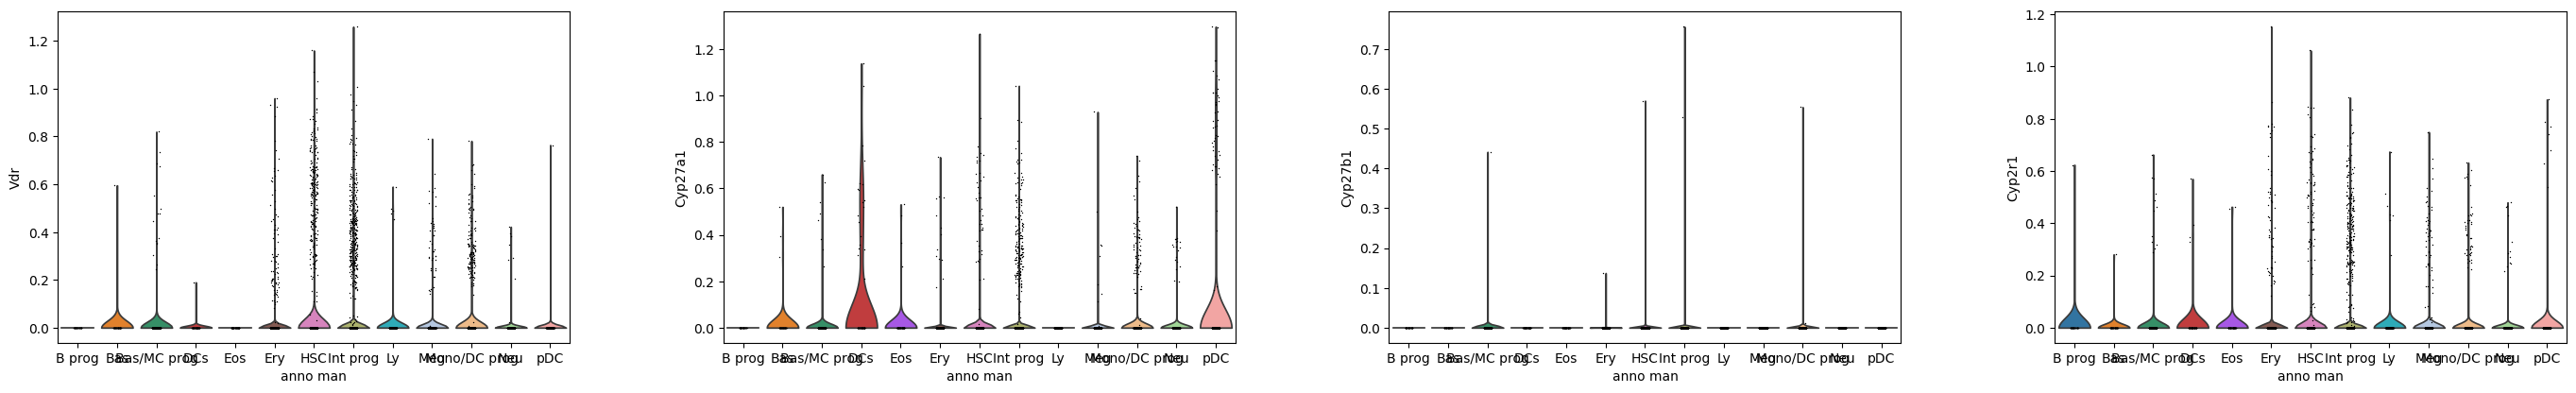

In [56]:
# sampling
# sc.pl.violin(new_adata, keys=["Vdr", "Cyp27a1", "Cyp27b1", "Cyp2r1"], groupby="anno_man")


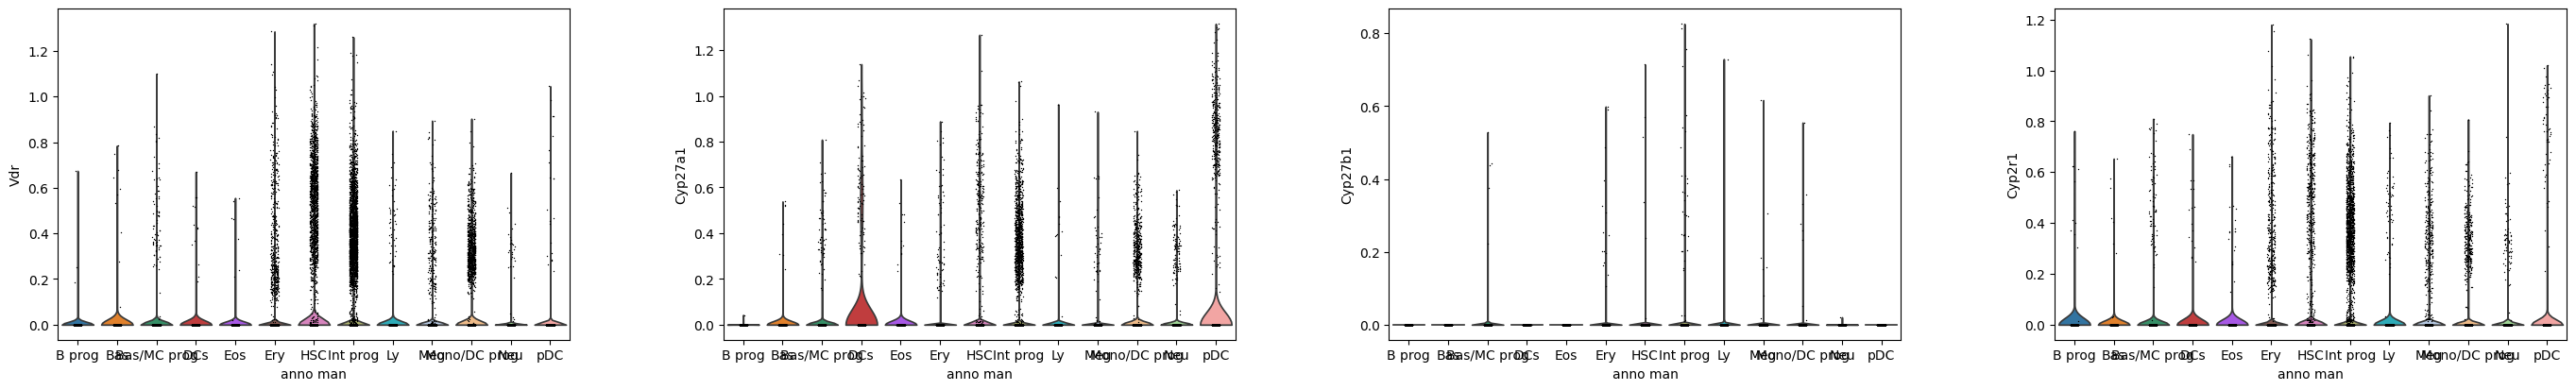

In [10]:
sc.pl.violin(new_adata, keys=["Vdr", "Cyp27a1", "Cyp27b1", "Cyp2r1"], groupby="anno_man")


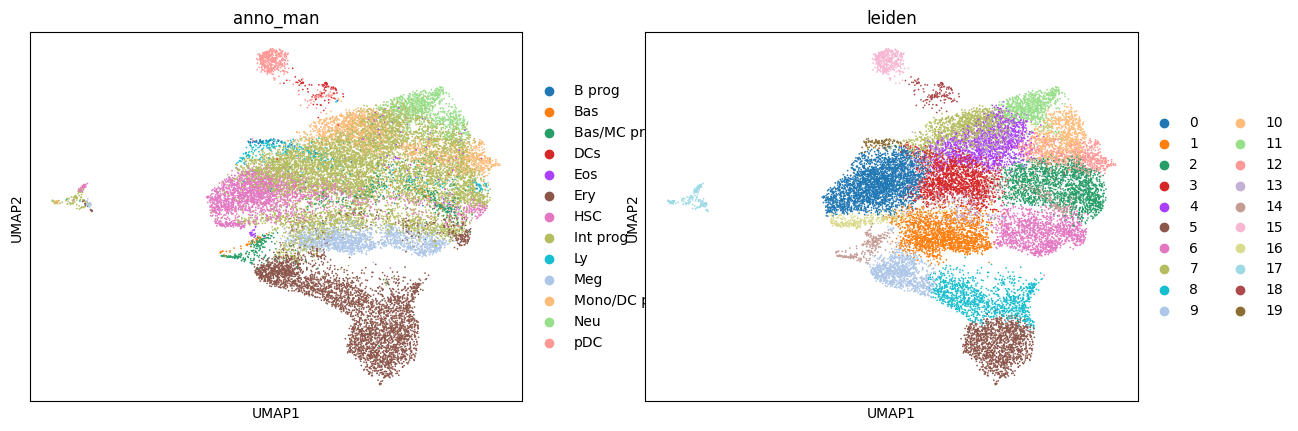

In [57]:
#sampling
# sc.pl.umap(new_adata, color=["anno_man", "leiden"])

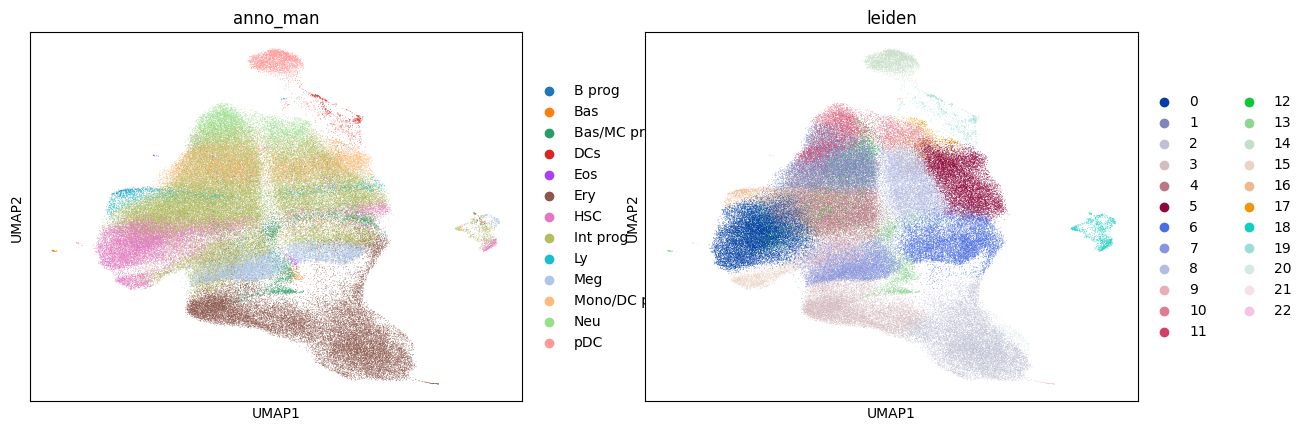

In [11]:
sc.pl.umap(new_adata, color=["anno_man", "leiden"])

In [12]:
# Find the DE genes x each cluster
sc.tl.rank_genes_groups(new_adata, groupby="anno_man", method="wilcoxon")

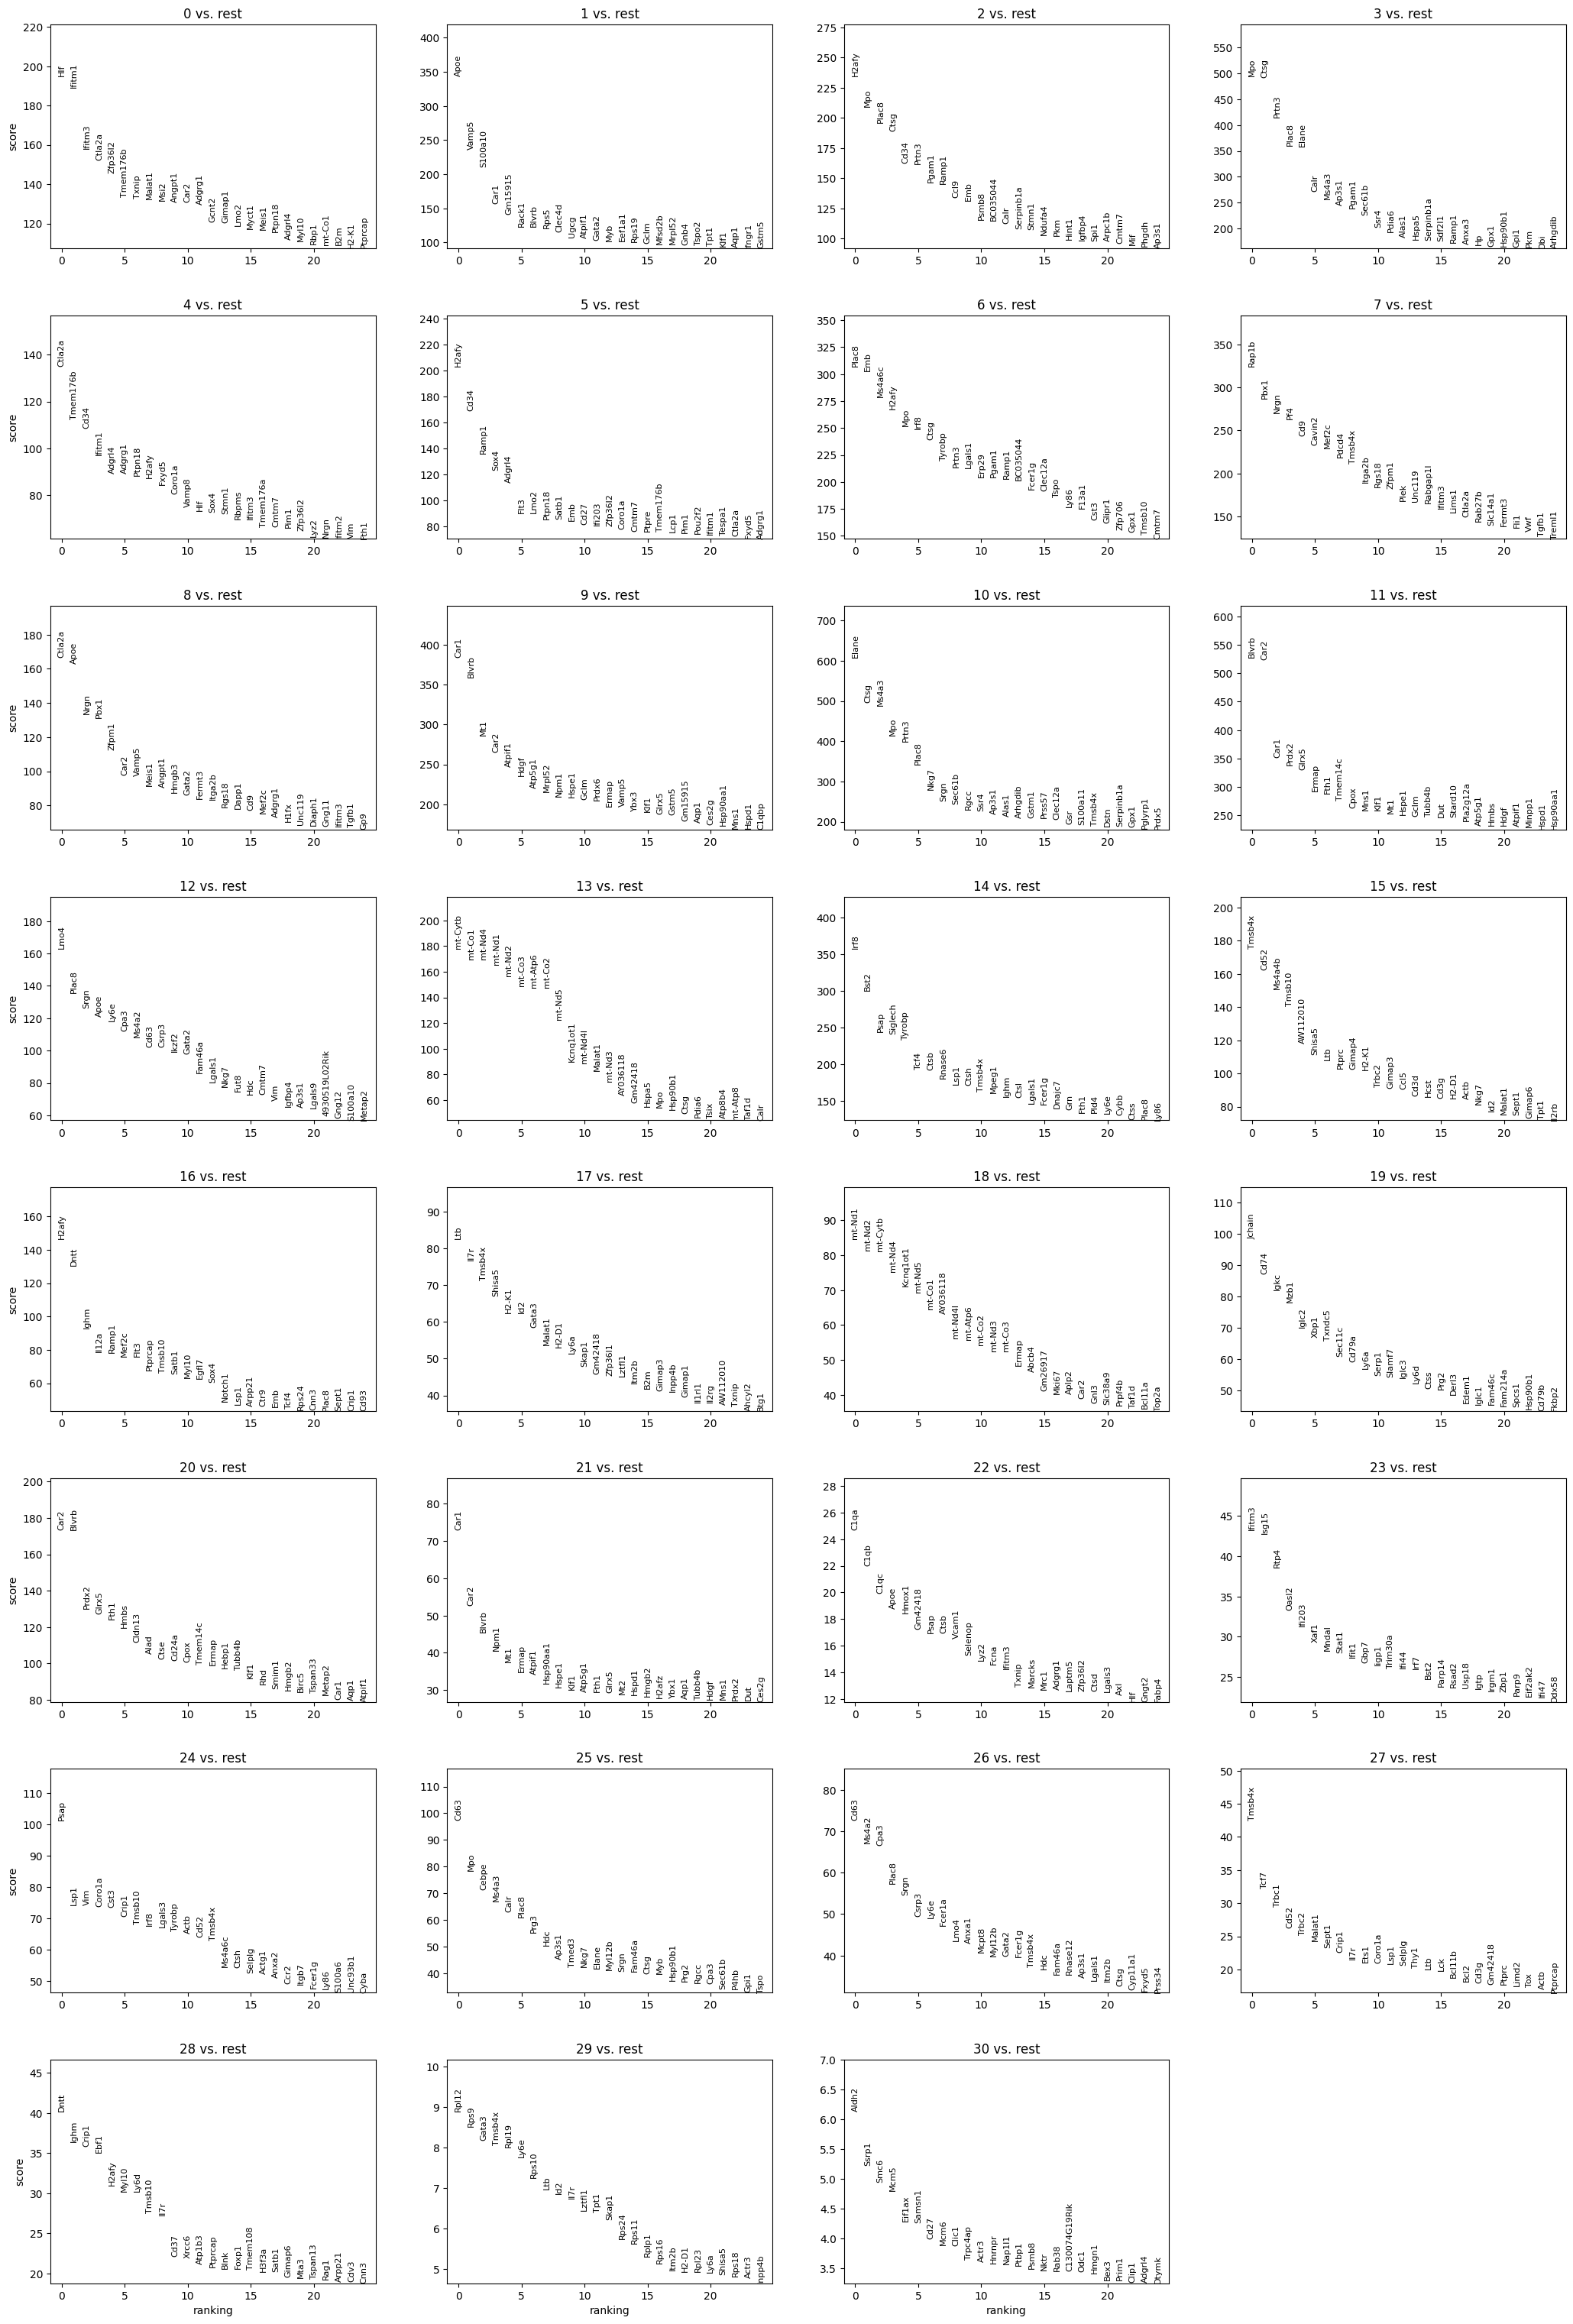

In [13]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

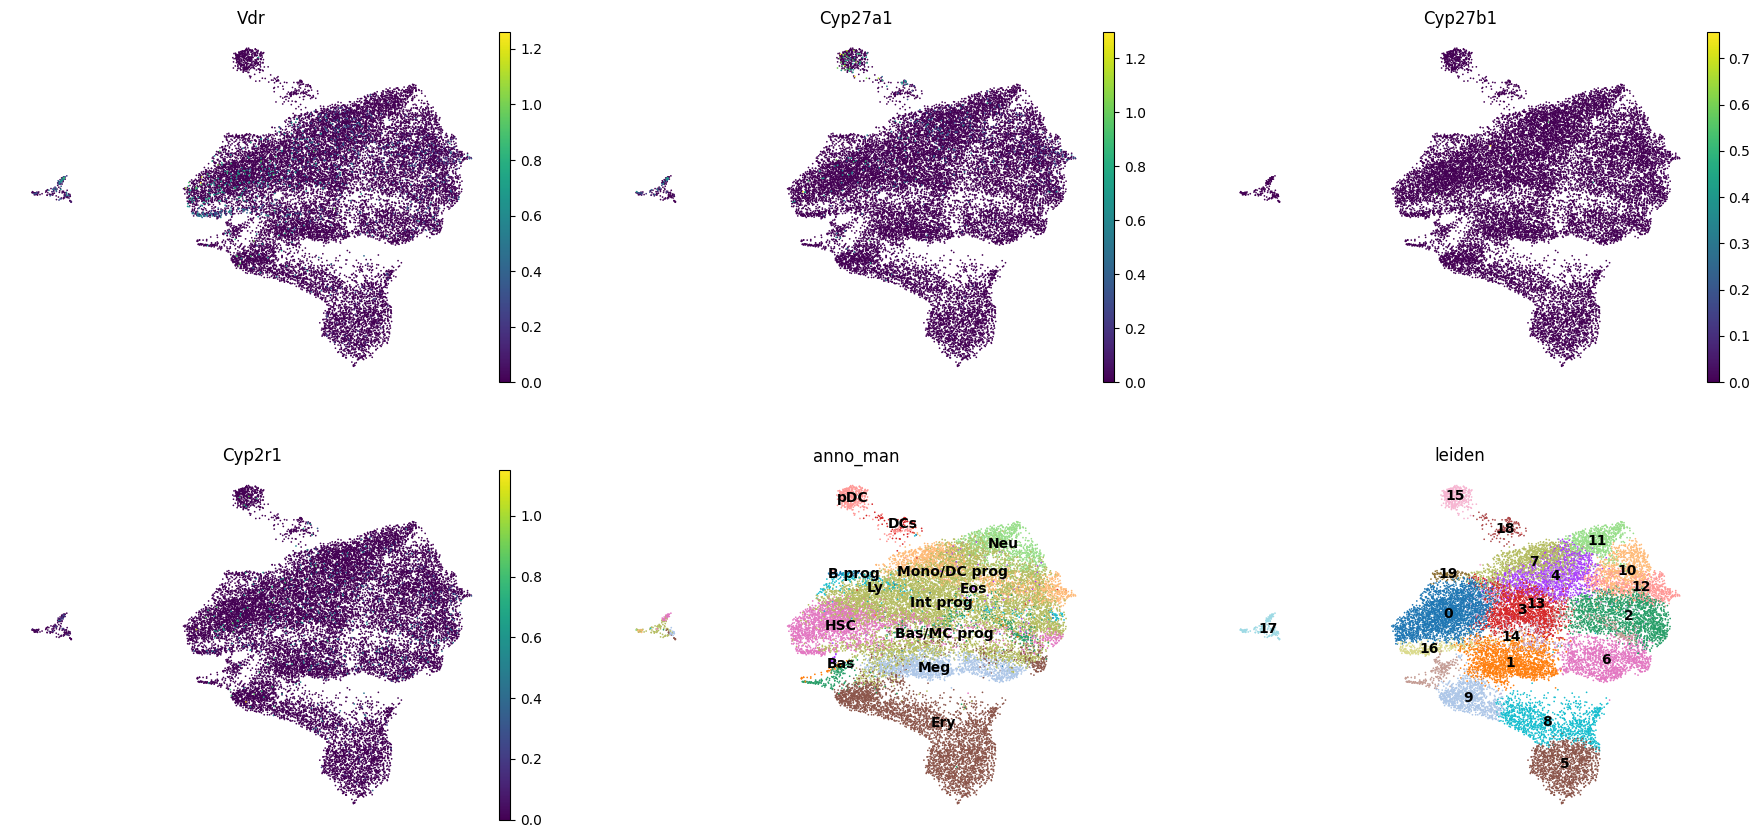

In [59]:
#sampling
sc.pl.umap(
    new_adata,
    color=["Vdr", "Cyp27a1", "Cyp27b1", "Cyp2r1", "anno_man", "leiden"],  # Flatten the list
    legend_loc="on data",
    frameon=False,
    ncols=3,
)


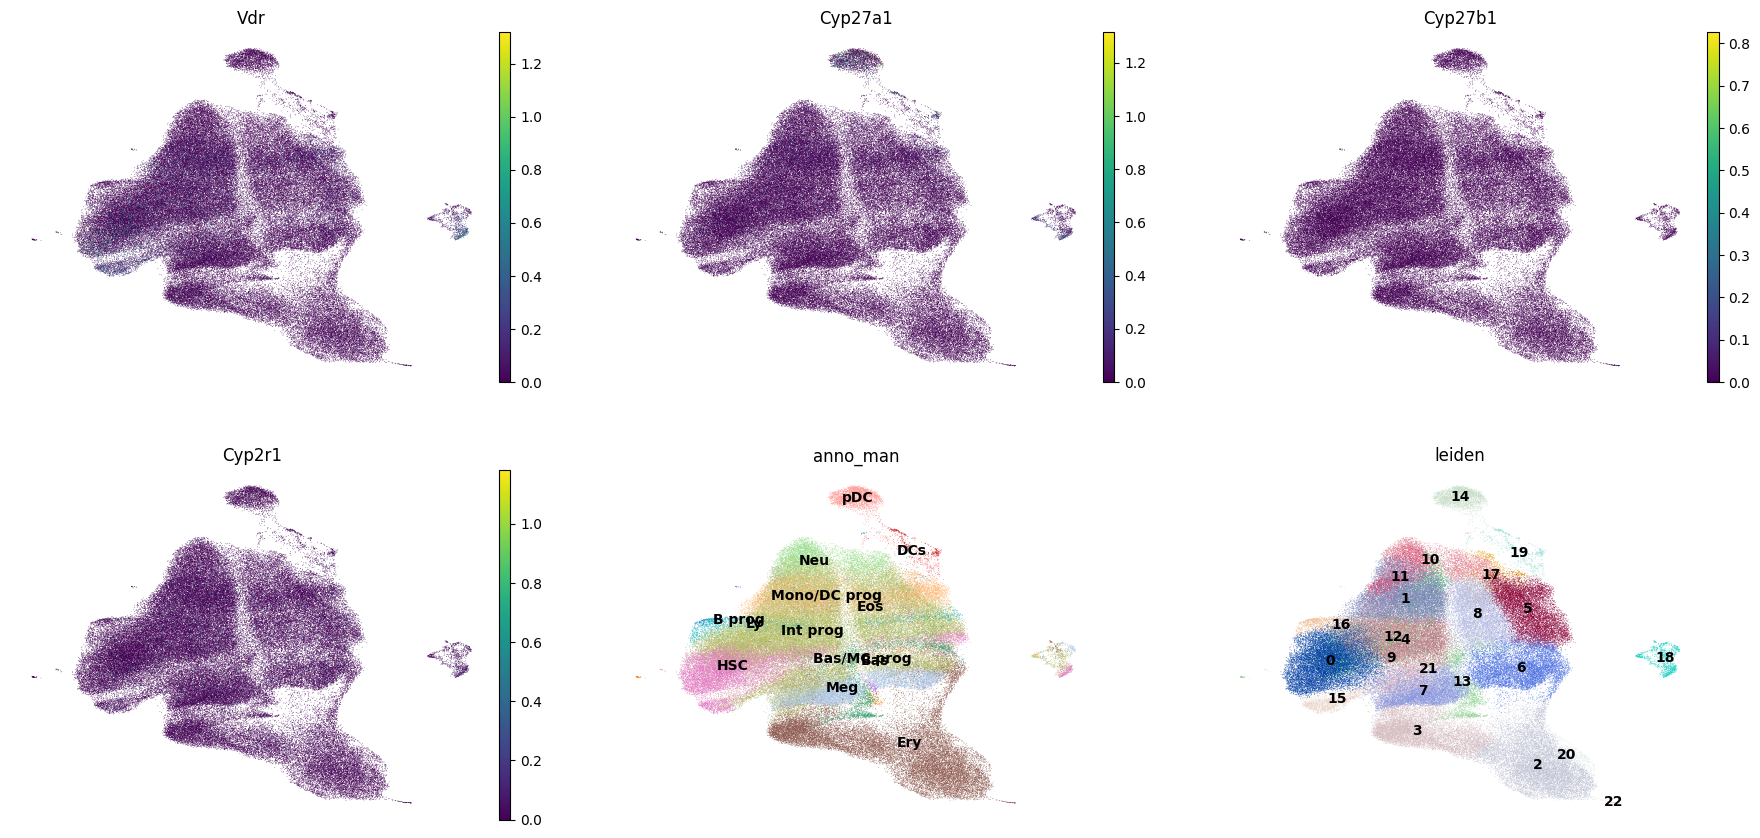

In [14]:
sc.pl.umap(
    new_adata,
    color=["Vdr", "Cyp27a1", "Cyp27b1", "Cyp2r1", "anno_man", "leiden"],  # Flatten the list
    legend_loc="on data",
    frameon=False,
    ncols=3,
)


In [60]:
#sampling
# Genes to check
genes_to_check = ["Vdr", "Cyp27a1", "Cyp27b1", "Cyp2r1"]

# Extract the DE results
rank_genes_groups = new_adata.uns["rank_genes_groups"]

# Initialize a dictionary to store the results
significant_genes = {}

# Check each gene in the results
for gene in genes_to_check:
    significant_genes[gene] = {}
    for group in rank_genes_groups['pvals'].dtype.names:
        # Check if the gene is in the names for the current group
        if gene in rank_genes_groups['names'][group]:
            # Get the index of the gene in the names array
            gene_index = list(rank_genes_groups['names'][group]).index(gene)
            # Get the corresponding p-value
            pval = rank_genes_groups['pvals'][group][gene_index]
            # Check if the p-value is below the threshold
            if pval < 0.05:
                significant_genes[gene][group] = pval

# Display the results
for gene, groups in significant_genes.items():
    if groups:
        print(f"{gene} is significant in the following groups (p < 0.05):")
        for group, pval in groups.items():
            print(f"  - {group}: p-value = {pval}")
    else:
        print(f"{gene} is not significant in any group (p < 0.05).")
# 

Vdr is significant in the following groups (p < 0.05):
  - Ery: p-value = 0.004110904108371038
  - HSC: p-value = 1.6445908186604634e-06
  - Mono/DC prog: p-value = 0.0013106807544418298
Cyp27a1 is significant in the following groups (p < 0.05):
  - DCs: p-value = 0.002297626316804699
  - Ery: p-value = 0.03565634267186675
  - pDC: p-value = 0.0015401705382458303
Cyp27b1 is not significant in any group (p < 0.05).
Cyp2r1 is not significant in any group (p < 0.05).


In [15]:
# Genes to check
genes_to_check = ["Vdr", "Cyp27a1", "Cyp27b1", "Cyp2r1"]

# Extract the DE results
rank_genes_groups = new_adata.uns["rank_genes_groups"]

# Initialize a dictionary to store the results
significant_genes = {}

# Check each gene in the results
for gene in genes_to_check:
    significant_genes[gene] = {}
    for group in rank_genes_groups['pvals'].dtype.names:
        # Check if the gene is in the names for the current group
        if gene in rank_genes_groups['names'][group]:
            # Get the index of the gene in the names array
            gene_index = list(rank_genes_groups['names'][group]).index(gene)
            # Get the corresponding p-value
            pval = rank_genes_groups['pvals'][group][gene_index]
            # Check if the p-value is below the threshold
            if pval < 0.05:
                significant_genes[gene][group] = pval

# Display the results
for gene, groups in significant_genes.items():
    if groups:
        print(f"{gene} is significant in the following groups (p < 0.05):")
        for group, pval in groups.items():
            print(f"  - {group}: p-value = {pval}")
    else:
        print(f"{gene} is not significant in any group (p < 0.05).")

Vdr is significant in the following groups (p < 0.05):
  - Bas/MC prog: p-value = 0.0068950620974498516
  - Ery: p-value = 1.0985238754834513e-15
  - HSC: p-value = 1.7765319212364238e-39
  - Ly: p-value = 0.04107724352830155
  - Meg: p-value = 0.00019190302921466896
  - Mono/DC prog: p-value = 2.692096048524005e-18
  - Neu: p-value = 3.356876108248569e-08
  - pDC: p-value = 8.598709174093809e-05
Cyp27a1 is significant in the following groups (p < 0.05):
  - DCs: p-value = 3.764137027550009e-10
  - Ery: p-value = 4.0132969792858863e-08
  - Meg: p-value = 0.004603431276048317
  - Mono/DC prog: p-value = 2.0877975801590222e-06
  - pDC: p-value = 7.758243753465699e-21
Cyp27b1 is not significant in any group (p < 0.05).
Cyp2r1 is significant in the following groups (p < 0.05):
  - Ery: p-value = 0.0029256866182477003


In [16]:
import decoupler as dc

In [63]:
net = dc.get_collectri(organism='human', split_complexes=False)

In [79]:
# Convert adata.var_names to uppercase
new_adata.var_names = new_adata.var_names.str.upper()

In [80]:
dc.run_ulm(
    mat=new_adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)

1269 features of mat are empty, they will be removed.
Running ulm on mat with 20000 samples and 20766 targets for 712 sources.


  0%|          | 0/2 [00:00<?, ?it/s]

In [81]:
new_adata.obsm['collectri_ulm_estimate'] = new_adata.obsm['ulm_estimate'].copy()
new_adata.obsm['collectri_ulm_pvals'] = new_adata.obsm['ulm_pvals'].copy()

In [84]:
acts = dc.get_acts(new_adata, obsm_key='ulm_estimate')
acts

AnnData object with n_obs × n_vars = 20000 × 712
    obs: 'anno_man', 'leiden'
    uns: 'anno_man_colors', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'ulm_estimate', 'ulm_pvals', 'collectri_ulm_estimate', 'collectri_ulm_pvals'

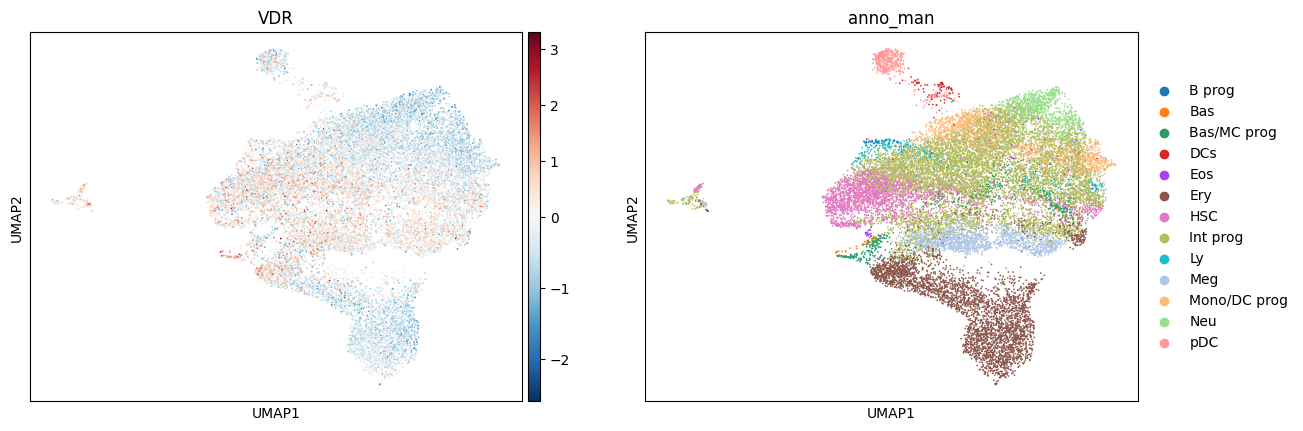

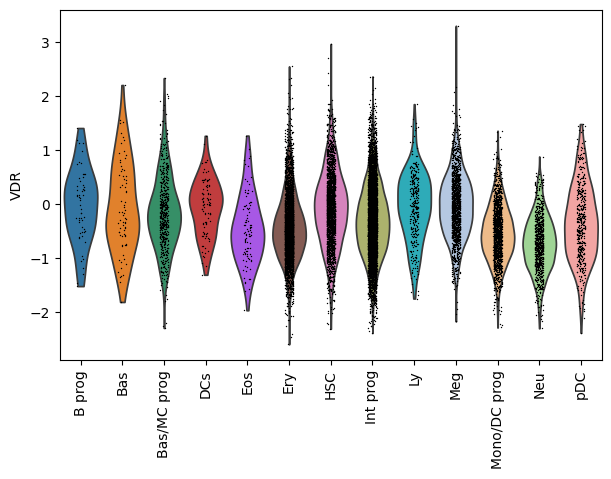

In [85]:
sc.pl.umap(acts, color=['VDR', 'anno_man'], cmap='RdBu_r', vcenter=0)
sc.pl.violin(acts, keys=['VDR'], groupby='anno_man', rotation=90)

In [17]:
#Full
net = dc.get_collectri(organism='human', split_complexes=False)

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

In [18]:
new_adata.var_names = new_adata.var_names.str.upper()

In [19]:
dc.run_ulm(
    mat=new_adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)

133 features of mat are empty, they will be removed.
Running ulm on mat with 130700 samples and 21902 targets for 719 sources.


  0%|          | 0/14 [00:00<?, ?it/s]

In [20]:
new_adata.obsm['collectri_ulm_estimate'] = new_adata.obsm['ulm_estimate'].copy()
new_adata.obsm['collectri_ulm_pvals'] = new_adata.obsm['ulm_pvals'].copy()

In [21]:
acts = dc.get_acts(new_adata, obsm_key='ulm_estimate')
acts

AnnData object with n_obs × n_vars = 130700 × 719
    obs: 'anno_man', 'leiden'
    uns: 'anno_man_colors', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'ulm_estimate', 'ulm_pvals', 'collectri_ulm_estimate', 'collectri_ulm_pvals'

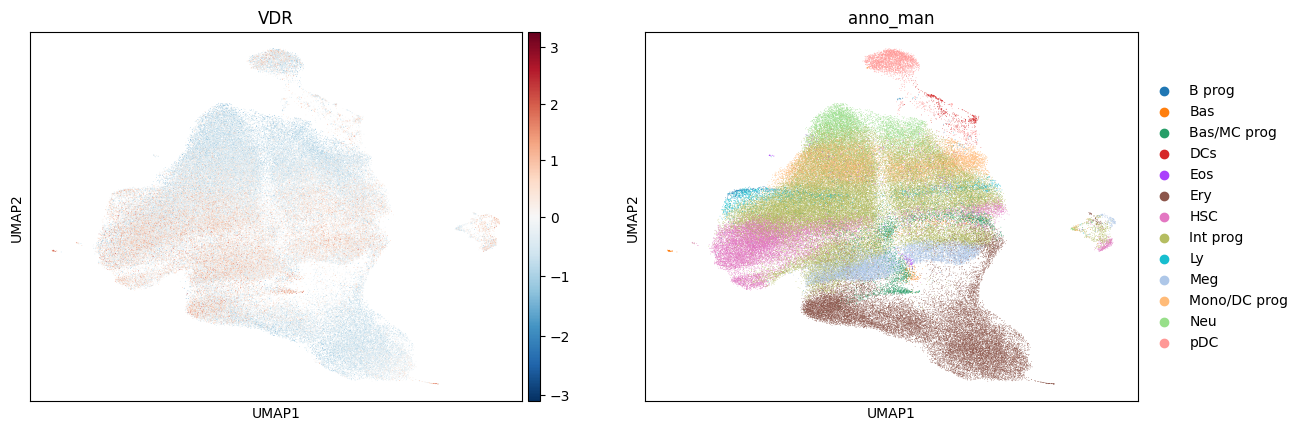

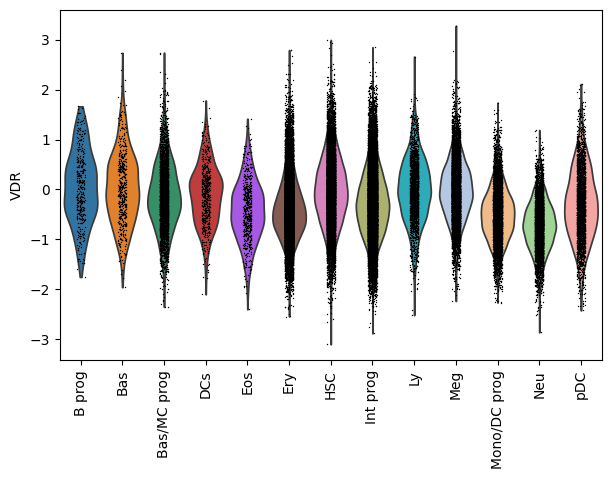

In [22]:
sc.pl.umap(acts, color=['VDR', 'anno_man'], cmap='RdBu_r', vcenter=0)
sc.pl.violin(acts, keys=['VDR'], groupby='anno_man', rotation=90)